# Sentiment Analysis

In [1]:
# Import libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
from datasets import Dataset, DatasetDict
# from datasets import load_dataset
# import evaluate

import transformers
from transformers import BertTokenizerFast, DataCollatorForTokenClassification, AutoModelForTokenClassification, TrainingArguments, Trainer, pipeline, TFBertForSequenceClassification, create_optimizer


from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization, Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam


c:\anaconda3\envs\torchdev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df_nlp = pd.read_csv('../data/bank_reviews3.csv')
df_nlp.columns
pd.unique(df_nlp['rating']) # 10 ratings
df_nlp.shape

pd.unique(df_nlp['rating'])


df_nlp['rating'].value_counts()



rating
5.0    550
4.0    257
3.0     71
4.5     45
2.0     30
3.5     21
1.0     13
0.5     10
2.5      2
1.5      1
Name: count, dtype: int64

In [63]:
mapping = {
    0:0.5,
    1:1.0,
    2:1.5,
    3:2.0,
    4:2.5,
    5:3.0,
    6:3.5,
    7:4.0,
    8:4.5,
    9:5.0
}

In [35]:
train_df = df_nlp.iloc[0:900, ]
test_df = df_nlp.iloc[900:, ]
train_reviews = train_df['review']
train_target = train_df['rating']
x_test = test_df['review']
y_test = test_df['rating']

# Split data into train and validation
x_train, x_val, y_train, y_val = train_test_split(train_reviews, train_target,
                 test_size = 0.2)

# x_train.columns

train_dataset = Dataset.from_dict({'text': x_train,
                                   'label': y_train})
test_dataset = Dataset.from_dict({'text':x_test,
                                 'label': y_test})

val_dataset = Dataset.from_dict({'text':x_val,
                                 'label':y_val})
dataset = DatasetDict({
    'train':train_dataset,
    'val':val_dataset,
    'test':test_dataset
})
# print(dataset)

In [36]:
# Tokenization
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)


# Encoding
max_len = 128
x_train_encoded = tokenizer.batch_encode_plus(x_train.tolist(),
                                              padding = True,
                                              truncation = True,
                                              max_length = max_len,
                                              return_tensors = 'tf')

x_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
                                            padding  = True,
                                            truncation = True,
                                            max_length = max_len,
                                            return_tensors = 'tf')

x_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
                                             padding = True,
                                             truncation = True,
                                             max_length = max_len,
                                             return_tensors  ='tf')

In [37]:
tokenizer.decode(x_test_encoded['input_ids'][1])

"[CLS] i ' m having my savings account with kotak mahindra bank. since its a zero balance account so that i had selected this bank. on yearly once, they are charging rs. 200 for the debit card. once i had faced a issue like they have blocked my account due to signature mismatch. once i visited their branch, they said it will take one week to resolve my issue. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

In [39]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_189 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 109489930 (417.67 MB)
Trainable params: 109489930 (417.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
# Tokenize
def preprocess_function(examples):
  return tokenizer(examples["text"],padding=True,truncation=True,)

tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

Map: 100%|██████████| 100/100 [00:00<00:00, 1119.31 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 720
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 180
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100
    })
})

In [41]:
pd.DataFrame({
    'text':tokenized_dataset['train'][:5]['text'],
    'label':tokenized_dataset['train'][:5]['label'],
    'input_ids':tokenized_dataset['train'][:5]['input_ids'],
    'token_type_ids':tokenized_dataset['train'][:5]['token_type_ids'],
    'attention_mask':tokenized_dataset['train'][:5]['attention_mask']
    })

,text,label,input_ids,token_type_ids,attention_mask
0,SBI service is good and I am happy to have an...,3.5,"[101, 24829, 2072, 2326, 2003, 2204, 1998, 104...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"In the year of 2014, i have started this savin...",4.0,"[101, 1999, 1996, 2095, 1997, 2297, 1010, 1045...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,I am using Syndicate bank salary account for t...,5.0,"[101, 1045, 2572, 2478, 16229, 2924, 10300, 40...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,I am having saving account with CITY UNION Ban...,5.0,"[101, 1045, 2572, 2383, 7494, 4070, 2007, 2103...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,I have opened 811 savings account from Kotak ...,3.0,"[101, 1045, 2031, 2441, 6282, 2487, 10995, 407...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [42]:
# Train Dataset
BATCH_SIZE = 8
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

# Test Dataset

tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    #collate_fn=data_collator
)

In [43]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'token_type_ids':dataset['token_type_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['label']

In [44]:
tf_train_dataset=tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset=tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [45]:
for i in tf_train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 196), dtype=int64, numpy=
array([[ 101, 1045, 2572, ...,    0,    0,    0],
       [ 101, 2441, 2026, ...,    0,    0,    0],
       [ 101, 1045, 2001, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 2031, ...,    0,    0,    0],
       [ 101, 1045, 2031, ...,    0,    0,    0],
       [ 101, 1045, 2572, ...,    0,    0,    0]], dtype=int64)>, 'token_type_ids': <tf.Tensor: shape=(8, 196), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)>, 'attention_mask': <tf.Tensor: shape=(8, 196), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int64)>}, <tf.Tensor: shape=(8,), dtype=float3

In [53]:
model=TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=10)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_265 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 109489930 (417.67 MB)
Trainable params: 109489930 (417.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
num_epochs = 3
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [55]:
# Optimizer
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [56]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)
    #run_eagerly=True)

In [57]:
history=model.fit(
    tf_train_dataset.take(1000),
    validation_data=tf_val_dataset,
    epochs=3)

Epoch 1/3
90/90 [==============================] - 2182s 20s/step - loss: 2.2614 - accuracy: 0.4583 - val_loss: 1.8923 - val_accuracy: 0.4400
Epoch 2/3
90/90 [==============================] - 1214s 13s/step - loss: 1.5030 - accuracy: 0.5542 - val_loss: 1.7050 - val_accuracy: 0.4400
Epoch 3/3
90/90 [==============================] - 3712s 42s/step - loss: 1.5350 - accuracy: 0.5597 - val_loss: 1.8038 - val_accuracy: 0.4400


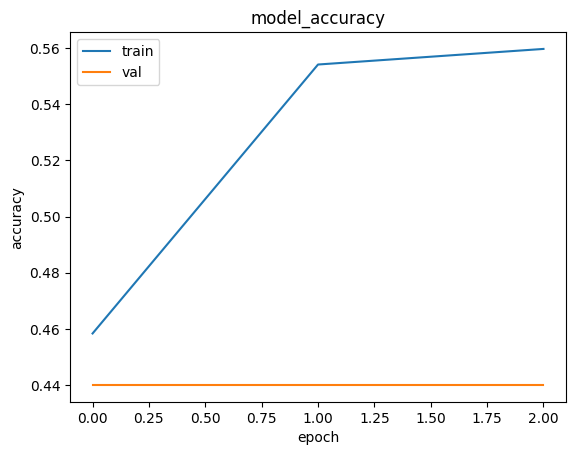

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [69]:
inputs = tokenizer(["This bank service is very quick",
                    "The time taken for the service is very fast, easy-to-use, the app is within our reach"], padding=True,return_tensors="tf")

logits = model(**inputs).logits
print(logits)

tf.Tensor(
[[-0.2319287  -0.08292964 -0.09443555  0.11029118  0.5401068   0.9680227
  -0.51318765 -0.32121783 -0.24361172 -0.21223971]
 [-0.15214263 -0.1445669  -0.01325799  0.11038916  0.6138146   0.9411849
  -0.48049983 -0.33044532 -0.20846575 -0.17973779]], shape=(2, 10), dtype=float32)


In [70]:
# Apply softmax to logits to get probabilities
probabilities = tf.nn.softmax(logits, axis=-1)

# Print the probabilities
pred_class = np.argmax(probabilities)
print(mapping[pred_class])

3.0


In [ ]:
# from itertools import chain
# from nltk.corpus import wordnet
# nltk.download('wordnet')
# synonyms = wordnet.synsets('quick')
# lemmas = set(chain.from_iterable([word.lemma_names() for word in synonyms]))
# lemmas

[nltk_data] Downloading package wordnet to C:\Users\Yang
[nltk_data]     LiTing\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


{'agile',
 'fast',
 'flying',
 'immediate',
 'nimble',
 'prompt',
 'promptly',
 'quick',
 'quickly',
 'ready',
 'speedy',
 'spry',
 'straightaway',
 'warm'}